In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import network_design as nd
from scipy.stats import entropy
import copy
from itertools import combinations

We want to use Bayesian methods to predict the most probable labeling of our network given that it was made from certain particles.

Say we have a network $A$ and we know the binding matrix $O$ and the labeling of our nodes $X$.
Then we know that
$$P(A\mid O,X)=\prod_{ij}p_{ij}^{A_{ij}}(1-p_{ij})^{1-A_{ij}}$$
where $p_{ij}=\min\left\{1,\min\left\{\frac{O_{\theta_i\theta_j}}{N_{\theta_j}},\frac{O_{\theta_j\theta_i}}{N_{\theta_i}}\right\}\right\}$.

Now what we want to solve is $P(X\mid O,A)$.
We know from Bayes that
$$
P(X\mid O,A)=\frac{P(A\mid O,X)P(O,X)}{P(A)}.
$$

Now we know that $O$ is fixed.
Thus we know that $P(A)=\sum_XP(A\mid X)$.
To solve this we would need to scan over all possible partitions of our nodes in $X$.

Instead, we find the $X$ with minimum description length. To do this, we first need to find our the number of possible networks that can be made for a given labeling $X$ and binding matrices $O_N$ and $O_L$.
This number will explode exponentially as many links can have different options.
To simplify, we apply the technique of SBM models but set $e_{rs}$ to be the number of expected links between two groups.

We know that $O\otimes X^T\mathbf{1}$ is the number of expected links between nodes of group $i$ and nodes of group $j$.
Thus the total entropy of our ensemble is simply, $\mathscr{S}=\frac{1}{2}\sum_{\theta_i,\theta_j}N_{\theta_i}N_{\theta_j}H_b\left(\frac{OX^T\mathbf{1}}{N_{\theta_i}N_{\theta_j}}\right)$.

Now we want to know the best labeling. This labeling will satisfy two constraints:
1. It will have the correct values of $e_{rs}$ and
2. It will be of minimal entropy of all the networks that satisfy condition (1).

To identify this, we use simulated annhealing on the function $f(x)=\|[\mathscr{S},e_{ij}-e_{ij}^*]\|$ for all $i,j$.

In [2]:
def colors(X):
    color = []
    for i in range(len(X)):
        if np.where(X[i] == 1)[0][0] == 1:
            color.append('r')
        elif np.where(X[i] == 1)[0][0] == 2:
            color.append('gold')
        else:
            color.append('deepskyblue')
    return color

In [23]:
def get_links_between_groups(A,X,mat = True):
    R = (X.T@A@X)
    R[np.diag_indices_from(R)] /= 2
    if mat:
        return R[np.triu_indices(X.shape[1])],R
    return R[np.triu_indices(X.shape[1])]

def H(x):
    return -x*np.log(x) - (1-x)*np.log(1-x)

def energy(params,lambda0=2):
    A, X, O = params
    # Get links between groups
    e, mat = get_links_between_groups(A,X)
    # Get optimal number of links between groups
    # e_star_1 = (X.T@O@X)[np.triu_indices(X.shape[1])]
    # e_star_2 = (X.T@O@X)[np.tril_indices(X.shape[1])]
    e_star_1 = (O*X.sum(axis=0))[np.triu_indices(X.shape[1])]
    e_star_2 = (O*X.sum(axis=0))[np.tril_indices(X.shape[1])]
    e_star = np.minimum(e_star_1,e_star_2)
    
    # Get diff
    diff = e - e_star
    # Link
    
    # Get entropy
    S = 1/2*np.nansum([mat[i,j]*np.log(mat[i,j]/(mat[i].sum()*mat[j].sum())) for j in range(X.shape[1]) for i in range(X.shape[1])])
    # total_energy = np.append(S,diff)
    
    # return np.linalg.norm(S,ord=1),S
    return S,diff

In [24]:
def find_rows_with_positive_values(matrix, columns, degree):
    # Create a mask for positive values in each specified column
    mask = np.ones(matrix.shape[0], dtype=bool)
    for col,deg in zip(columns,degree):
        mask &= (matrix[:, col] >= deg)
    # Get indices where all conditions are satisfied
    return np.where(mask)[0]

def generate_smart_node_assignments(g,O):
    # initialize matrix
    X = np.zeros((g.number_of_nodes(),O.shape[0]))
    for i in range(g.number_of_nodes()):
        # Get neighbors
        neighbors = g.neighbors(i)
        labels = []
        for n in neighbors:
            try:
                labels.append(np.where(X[n] == 1)[0][0])
            except:
                continue
        labels = np.array(labels)
        uniq_labels = np.unique(labels)
        degrees = np.array([len(labels[labels == l]) for l in uniq_labels])
        viable_labels = find_rows_with_positive_values(O,uniq_labels,degrees)
        if len(viable_labels) == 0:
            l = np.random.choice(np.arange(O.shape[0]))
        else:
            l = np.random.choice(viable_labels)
        X[i,l] = 1
    return X
            

def mh(f,g,O,burn_in=10000,init_T=1,max_iters=100,cooling_factor=.95,cooldown=100):
    """
    Perform metropolis-hastings
    
    Parameters:
        f: function to minimize
        A (ndarray) - adjacency matrix
        O (ndarray) - binding matrix
        burn_in (ndarray) - number of iterations for burn in period
        init_T (float) - initial temperature
        max_iters (int) - maximum number of iterations
        cooling_factor (float) - factor to change temperature
    
    Return:
        X (ndarray) - node labels
        energy (float) - energy of final labeling
        entropy (float) - entropy of labeling
    """
    energies = []
    A = nx.adjacency_matrix(g).toarray()
    # Create initial labeling
    # X0 = nd.generate_node_assignments(A.shape[0],O.shape[0])
    X0 = generate_smart_node_assignments(g,O)
    E0,diff = f((A,X0,O))
    labels = np.arange(O.shape[0])
    for _ in range(burn_in):
        # Update node labeling
        # Choose node
        k = np.random.choice(list(g.nodes()))
        # Choose random labeling
        # l = np.random.choice(labels)
        # Check neighbors
        neighbors = g.neighbors(k)
        # Get labels of neighbors
        labels = np.array([np.where(X0[n] == 1)[0][0] for n in neighbors])

        uniq_labels = np.unique(labels)
        degrees = np.array([len(labels[labels == l]) for l in uniq_labels])
        # Get viable labels
        viable_labels = find_rows_with_positive_values(O,uniq_labels,degrees)
        if len(viable_labels) == 0:
            continue
        else:
            l = np.random.choice(viable_labels)
        
        X1 = copy.deepcopy(X0)
        X1[k] = np.zeros(X1.shape[1])
        X1[k,l] = 1

        # Calculate new energy
        E1,diff = f((A,X1,O))
        # if len(diff[diff>0]) > 0:
        #     E1 = 10e2
        diff_E = np.linalg.norm(E0 - E1)
        random_num = np.random.random()
        if random_num < np.min([1,np.exp(diff_E / init_T)]):
            X0 = X1
            E0 = E1
        energies.append(E0)
    
    T = init_T
    for _ in range(max_iters):
        T *= cooling_factor
        # Update node labeling
        # Choose node
        k = np.random.choice(list(g.nodes()))
        # Choose random labeling
        # l = np.random.choice(labels)
        # Check neighbors
        neighbors = g.neighbors(k)
        # Get labels of neighbors
        labels = np.array([np.where(X0[n] == 1)[0][0] for n in neighbors])
        uniq_labels = np.unique(labels)
        degrees = np.array([len(labels[labels == l]) for l in uniq_labels])
        # Get viable labels
        viable_labels = find_rows_with_positive_values(O,uniq_labels,degrees)
        if len(viable_labels) == 0:
            continue
        else:
            l = np.random.choice(viable_labels)
        X1 = copy.deepcopy(X0)
        X1[k] = np.zeros(X1.shape[1])
        X1[k,l] = 1

        # Calculate new energy
        E1,diff = f((A,X1,O))
        # if len(diff[diff>0]) > 0:
        #     E1 = 10e2
        diff_E = np.linalg.norm(E0 - E1)
        random_num = np.random.random()
        if random_num < np.min([1,np.exp(diff_E / T)]):
            X0 = X1
            E0 = E1
        energies.append(E0)
        
    return X0, E0, diff_E, energies

In [25]:
def new_energy(params,lambda0=2):
    A, X, O = params
    # Get links between groups
    e, mat = get_links_between_groups(A,X)
    # Get optimal number of links between groups
    # e_star_1 = (X.T@O@X)[np.triu_indices(X.shape[1])]
    # e_star_2 = (X.T@O@X)[np.tril_indices(X.shape[1])]
    e_star_1 = (O*X.sum(axis=0))[np.triu_indices(X.shape[1])]
    e_star_2 = (O*X.sum(axis=0))[np.tril_indices(X.shape[1])]
    e_star = np.minimum(e_star_1,e_star_2)
    
    # Get diff
    diff = e - e_star
    # Link
    
    # Get entropy
    S = 1/2*np.nansum([mat[i,j]*np.log(mat[i,j]/(mat[i].sum()*mat[j].sum())) for j in range(X.shape[1]) for i in range(X.shape[1])])
    total_energy = np.append(S,np.abs(diff))
    
    # return np.linalg.norm(S,ord=1),S
    return np.linalg.norm(total_energy,ord=1),diff

In [26]:
def canonical_energy(params):
    A, X, O = params
    _, P = nd.canonical_ensemble(X.sum(axis=0).astype(int),O,X,ret_P=True)
    probability = np.prod([P[i,j]**A[i,j]*(1-P[i,j])**(1-A[i,j]) for j in range(i,A.shape[0]) for i in range(A.shape[0])])
    if probability == 0:
        return np.inf, np.zeros(int(A.sum()/2))
    return -probability*np.log(probability) - (1-probability)*np.log(1-probability), np.zeros(int(A.sum()/2))

In [78]:
true_X = nd.generate_node_assignments(10,3)
cap = nd.assign_particles(3,4)
O = nd.create_O(cap)

In [79]:
g = nd.new_soup_of_nodes(true_X,nd.create_capacity(true_X,cap))

In [80]:
A = nx.adjacency_matrix(g).toarray()

In [81]:
new_X, new_ent,diff,energies = mh(energy,g,O,max_iters=10000,cooling_factor=.98)

/tmp/ipykernel_17238/1219016132.py:27: RuntimeWarning: divide by zero encountered in log
  S = 1/2*np.nansum([mat[i,j]*np.log(mat[i,j]/(mat[i].sum()*mat[j].sum())) for j in range(X.shape[1]) for i in range(X.shape[1])])
/tmp/ipykernel_17238/1219016132.py:27: RuntimeWarning: invalid value encountered in scalar multiply
  S = 1/2*np.nansum([mat[i,j]*np.log(mat[i,j]/(mat[i].sum()*mat[j].sum())) for j in range(X.shape[1]) for i in range(X.shape[1])])
/tmp/ipykernel_17238/1219016132.py:27: RuntimeWarning: invalid value encountered in scalar divide
  S = 1/2*np.nansum([mat[i,j]*np.log(mat[i,j]/(mat[i].sum()*mat[j].sum())) for j in range(X.shape[1]) for i in range(X.shape[1])])
/tmp/ipykernel_17238/4168715584.py:123: RuntimeWarning: overflow encountered in exp
  if random_num < np.min([1,np.exp(diff_E / T)]):


In [82]:
test_X = gener

(array([[1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]]),
 np.float64(0.0))

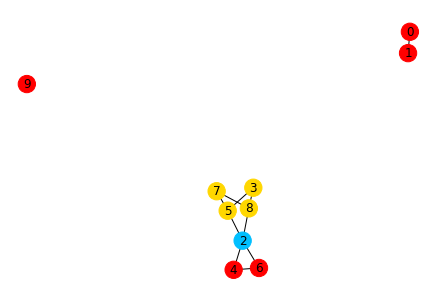

In [83]:
pos = nx.spring_layout(g)
nx.draw(g,node_color=colors(true_X),pos=pos,with_labels=True)

In [84]:
new_ent, energy((A,true_X,O)),energy((A,new_X,O))

/tmp/ipykernel_17238/1219016132.py:27: RuntimeWarning: divide by zero encountered in log
  S = 1/2*np.nansum([mat[i,j]*np.log(mat[i,j]/(mat[i].sum()*mat[j].sum())) for j in range(X.shape[1]) for i in range(X.shape[1])])
/tmp/ipykernel_17238/1219016132.py:27: RuntimeWarning: invalid value encountered in scalar multiply
  S = 1/2*np.nansum([mat[i,j]*np.log(mat[i,j]/(mat[i].sum()*mat[j].sum())) for j in range(X.shape[1]) for i in range(X.shape[1])])


(np.float64(-23.665229644817224),
 (np.float64(-15.602587079287947), array([ 0., -1., -3.,  1.,  0., -4.])),
 (np.float64(-23.665229644817224), array([ 0.,  0., -2., -3.,  2., -7.])))

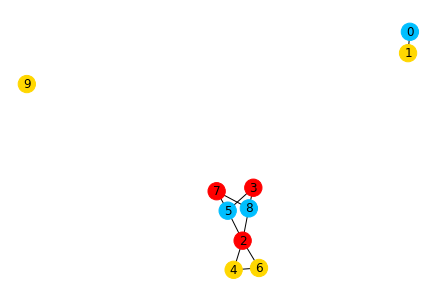

In [85]:
nx.draw(g,node_color=colors(new_X),pos=pos,with_labels=True)

In [86]:
O

array([[0., 2., 2.],
       [3., 1., 0.],
       [1., 1., 2.]])

(array([1970., 4478.,  620., 4641., 4116.,  926., 1460.,  219.,  228.,
          15.]),
 array([-18.86696785, -18.24146482, -17.61596179, -16.99045876,
        -16.36495573, -15.7394527 , -15.11394967, -14.48844664,
        -13.86294361, -13.23744058, -12.61193755]),
 <BarContainer object of 10 artists>)

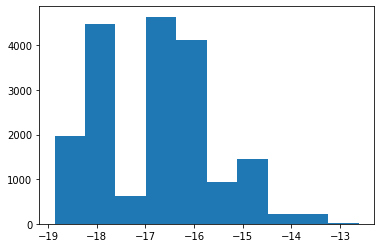

In [43]:
plt.hist(energies)

In [333]:
X0 = true_X
neighbors = g.neighbors(1)
# Get labels of neighbors
labels = np.array([np.where(X0[n] == 1)[0][0] for n in neighbors])
uniq_labels = np.unique(labels)
degrees = np.array([len(labels[labels == l]) for l in uniq_labels])
# Get viable labels
viable_labels = find_rows_with_positive_values(O,labels,degrees)

In [493]:
test_X = generate_smart_node_assignments(g,O)

In [494]:
new_energy((A,test_X,O))

/tmp/ipykernel_20666/4268664553.py:17: RuntimeWarning: divide by zero encountered in log
  S = 1/2*np.nansum([mat[i,j]*np.log(mat[i,j]/(mat[i].sum()*mat[j].sum())) for j in range(X.shape[1]) for i in range(X.shape[1])])
/tmp/ipykernel_20666/4268664553.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  S = 1/2*np.nansum([mat[i,j]*np.log(mat[i,j]/(mat[i].sum()*mat[j].sum())) for j in range(X.shape[1]) for i in range(X.shape[1])])


(np.float64(20.59167373200866), array([-4., -3.,  2.,  0.,  1., -4.]))

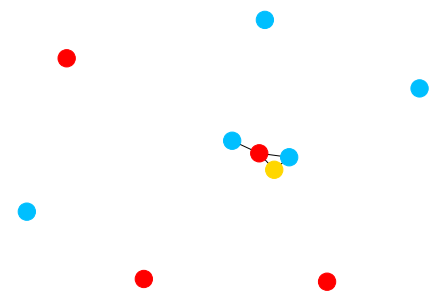

In [500]:
nx.draw(g,node_color=colors(X))

In [498]:
X = np.zeros((g.number_of_nodes(),O.shape[0]))
all_assigned = False
while all_assigned is False:
    node_order = list(g.nodes())
    np.random.shuffle(node_order)
    for i in node_order:
        # Get neighbors
        neighbors = g.neighbors(i)
        labels = []
        for n in neighbors:
            try:
                labels.append(np.where(X[n] == 1)[0][0])
            except:
                continue
        labels = np.array(labels)
        uniq_labels = np.unique(labels)
        degrees = np.array([len(labels[labels == l]) for l in uniq_labels])
        if len(uniq_labels) == 0:
            l = np.random.choice(np.arange(O.shape[0]))
        else:
            viable_labels = find_rows_with_positive_values(O,uniq_labels,degrees)
            try:
                l = np.random.choice(viable_labels)
            except:
                continue
        X[i] = np.zeros(O.shape[0])
        X[i,l] = 1
    if X.sum() == g.number_of_nodes():
        all_assigned = True

In [499]:
O

array([[1., 1., 2.],
       [4., 0., 0.],
       [1., 1., 2.]])

In [438]:
O

array([[0., 3., 1.],
       [2., 1., 1.],
       [0., 2., 2.]])

In [276]:
def find_rows_with_positive_values(matrix, columns):
    # Create a mask for positive values in each specified column
    mask = np.ones(matrix.shape[0], dtype=bool)
    for col in columns:
        mask &= (matrix[:, col] > 0)
    # Get indices where all conditions are satisfied
    return np.where(mask)[0]

In [312]:
find_rows_with_positive_values(O,[0,2,2,2])

array([0, 1])

In [221]:
new_g = nd.new_soup_of_nodes(new_X,nd.create_capacity(new_X,cap))

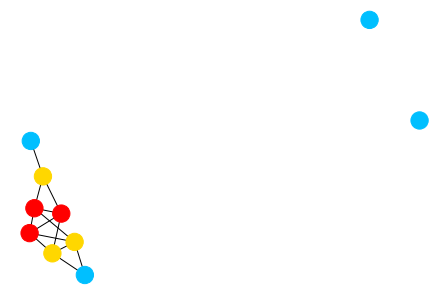

In [222]:
nx.draw(new_g,node_color=colors(new_X))

In [228]:
e_star_1 = (O*new_X.sum(axis=0))[np.triu_indices(new_X.shape[1])]
e_star_2 = (O*new_X.sum(axis=0))[np.tril_indices(new_X.shape[1])]
e_star = np.minimum(e_star_1,e_star_2)
e_star

array([0., 0., 6., 4., 6., 3.])

In [229]:
new_X

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [231]:
get_links_between_groups(A,new_X,mat=False) - e_star

array([ 2.,  5., -5., -4., -6., -3.])

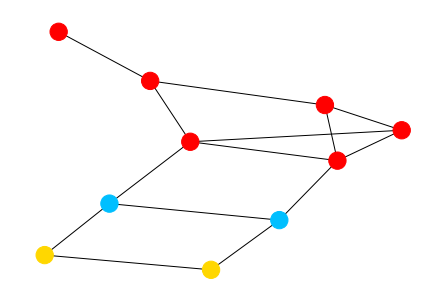

In [206]:
nx.draw(g,pos=pos,node_color=colors(true_X))

In [34]:
np.minimum((X.T@O@X)[np.tril_indices(X.shape[1])],(X.T@O@X)[np.triu_indices(X.shape[1])])

array([13.,  1.,  1.,  1.,  0.,  2.])

In [3]:
nd.generate_node_assignments?

Signature: nd.generate_node_assignments(N, k)
Docstring: Create random X matrix on N particles which each can be one of k different classes
File:      /work/ccnr/glover.co/net_design/network_design.py
Type:      function


In [117]:
A.sum(axis=1)

array([1, 4, 1, 4, 4, 4, 2, 4, 2, 4])

In [7]:
cap = nd.assign_particles(3,[4,2,3])

In [9]:
O = np.array([[1,.5,.5],[2,1.5,.5],[1,1,0]])

In [48]:
O_L = np.array([[1,0,0],[0,1,1],[1,0,0],[1,0,0],[0,1,0],[0,1,1],[1,0,0],[0,1,0]])

In [80]:
X = nd.generate_node_assignments(10,3)
N = X.sum(axis=0)

In [81]:
O_L@N/np.linalg.norm(O_L@N,ord=np.inf)

array([0.25, 1.  , 0.25, 0.25, 0.25, 1.  , 0.25, 0.25])

In [82]:
O_L_norm = (O_L*N)/np.linalg.norm(O_L*N,ord=1,axis=1)[:,None]

In [83]:
link_to_node = np.array([[1,0,0],[1,0,0],[0,1,0],[0,1,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1]]).T

In [119]:
O = link_to_node@O_L_norm

In [197]:
np.sum(get_links_between_groups(A,true_X)[0])

np.float64(24.0)

In [199]:
g.number_of_edges()

14

In [142]:
edges = np.zeros(1000)
for i in range(1000):
    g = nd.canonical_ensemble(N.astype(int),O,X)
    edges[i] = g.number_of_edges()

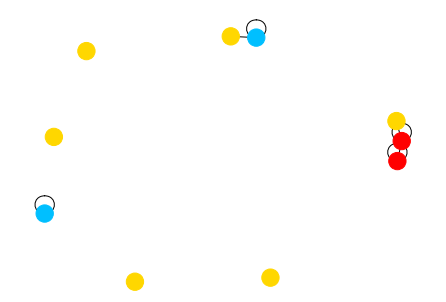

In [143]:
nx.draw(g,node_color=colors(X))

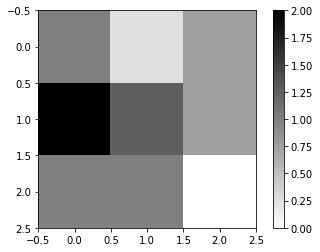

In [144]:
plt.imshow(O,cmap='gray_r')
plt.colorbar()

(array([ 44.,  80., 131., 192., 194., 250.,  61.,  32.,   9.,   7.]),
 array([ 2. ,  3.2,  4.4,  5.6,  6.8,  8. ,  9.2, 10.4, 11.6, 12.8, 14. ]),
 <BarContainer object of 10 artists>)

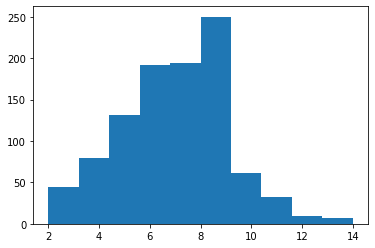

In [145]:
plt.hist(edges)

In [153]:
edge_count = 0
for i in range(3):
    for j in range(i,3):
        edge_count+=np.min([(O*N[:,None])[i,j],(O*N[:,None])[j,i]])

In [154]:
edge_count, edges.mean()


(np.float64(8.0), np.float64(6.871))

In [151]:
O*N[:,None]

array([[2. , 0.5, 1.5],
       [4. , 2.5, 1.5],
       [6. , 6. , 0. ]])

In [152]:
O*N

array([[2. , 0.5, 4.5],
       [4. , 2.5, 4.5],
       [2. , 2. , 0. ]])

In [150]:
def create_network(O_L,P_L,N_L):
    # Get node pairs
    O_L = copy.deepcopy(O_L)
    pairs = list(combinations(np.arange(O_L.shape[0]),2))
    for idx1, idx2 in pairs:
        e1, e2 = O_L[[idx1,idx2],:]
        particle1, particle2 = P_L[[particle_1,particle_2],:]
        particle1 = np.where(particle1 == 1)[0][0]
        particle2 = np.where(particle2 == 1)[0][0]
        node1 = np.where(
        
        if e1[particle2] == 1 and e2[particle1] == 1:
            g.add_edge(

4.5

Alternative approach: canonical ensemble.
We have
$$P(X\mid G,N,O)=\frac{P(G\mid X,N,O)P(X\mid N,O)}{P(G\mid N,O)}=\frac{P(G\mid X,N,O)P(N\mid X,O)P(X\mid O)}{P(G\mid N,O)P(N\mid O)}$$

We will assume our prior $P(X\mid O)$ is uniform at the moment.
We note that there are $|\Theta|^N$ possible $X$ matrices.
Thus $P(X\mid O)=\frac{1}{|\Theta|^N}$.

In [33]:
capacity = {0:{0:1,1:2,2:1},1:{0:3,1:1,2:0},2:{0:2,1:2,2:0}}

In [34]:
g = nx.Graph()
g.add_edge(0,1)
g.add_edge(0,2)
g.add_edge(0,3)
g.add_edge(3,4)
g.add_edge(5,6)
g.add_node(7)
g.add_node(8)
g.add_node(9)

In [35]:
X_true = np.array([[1,0,0],[0,1,0],[0,0,1],[0,1,0],[0,1,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1],[0,0,1]])


In [36]:
nd.create_O(capacity)

array([[1., 2., 1.],
       [3., 1., 0.],
       [2., 2., 0.]])

In [39]:
g = nd.new_soup_of_nodes(X_true,nd.create_capacity(X_true,capacity))

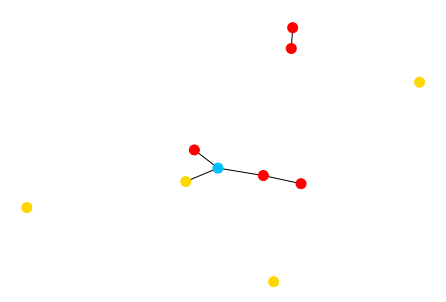

In [40]:
nx.draw(g,node_color=colors(X_true),node_size=100,width=1)

In [41]:
A = nx.adjacency_matrix(g).toarray()

In [42]:
nd.probability(A,X_true.sum(axis=0).astype(int),nd.create_O(capacity),X_true)

np.float64(0.0)

In [45]:
def inverse_canonical(A,prior,O,burn_in=100,num_samples=1000):
    samples = []
    sample_count = dict()
    T = 1
    # Initialize label
    p0 = 0
    while p0 == 0:
        X_cur = generate_smart_node_assignments(nx.from_numpy_array(A),O)
        p0 = nd.probability(A,X_cur.sum(axis=0).astype(int),O,X_cur)
    for _ in range(burn_in):
        # New sample
        p1 = 0
        while p1 == 0:
            X_new = generate_smart_node_assignments(nx.from_numpy_array(A),O)
            p1 = nd.probability(A,X_new.sum(axis=0).astype(int),O,X_new)
        alpha = np.exp(p0 - p1 / T)
        if alpha < np.random.random():
            X_cur = X_new
            p0 = p1
    
    for i in range(num_samples):
         # New sample
        p1 = 0
        while p1 == 0:
            X_new = generate_smart_node_assignments(nx.from_numpy_array(A),O)
            p1 = nd.probability(A,X_new.sum(axis=0).astype(int),O,X_new)
        alpha = np.exp(p0 - p1 / T)
        if alpha < np.random.random():
            X_cur = X_new
            p0 = p1
        if tuple(np.where(X_cur==1)[1]) not in samples:
            sample_count[len(samples)] = 1
            samples.append(tuple(np.where(X_cur==1)[1]))
        else:
            sample_count[samples.index(tuple(np.where(X_cur==1)[1]))] += 1
        T *= .95
    
    return sample_count, samples

In [46]:
count, samples = inverse_canonical(A,1/3**10,nd.create_O(capacity),burn_in=1000,num_samples=10000)

In [47]:
nd.probability(A,X_true.sum(axis=0).astype(int),O,X_true)

np.float64(0.0)

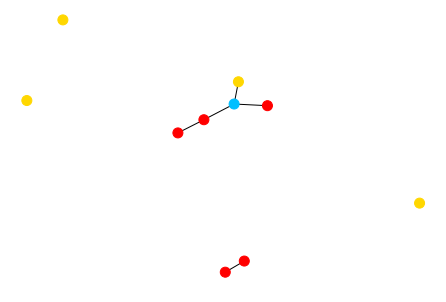

In [48]:
nx.draw(g,node_color=colors(X_true),node_size=100,width=1)

In [49]:
O = nd.create_O(capacity)
X = np.zeros((10,3))
X[np.arange(10),np.array(samples[np.argmax(list(count.values()))])] = 1
nd.probability(A,X.sum(axis=0).astype(int),O,X)

np.float64(1.4339859953962238e-10)

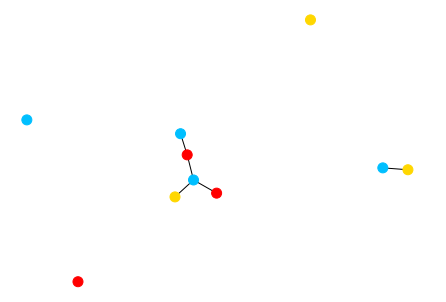

In [50]:
nx.draw(g,node_color=colors(X),node_size=100,width=1)

In [241]:
nd.create_O(capacity)

array([[1., 1., 0.],
       [2., 1., 0.],
       [0., 2., 2.]])

In [51]:
values = np.sort(np.array(list(count.values())))
idx = np.argsort(np.array(list(count.values())))

<BarContainer object of 4323 artists>

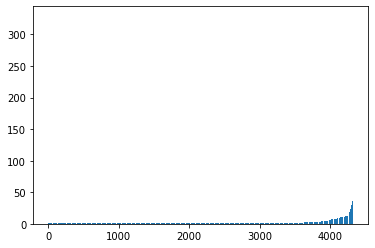

In [52]:
plt.bar(np.arange(len(values)),values)

In [53]:
new_g = nd.new_soup_of_nodes(X,nd.create_capacity(X,capacity))

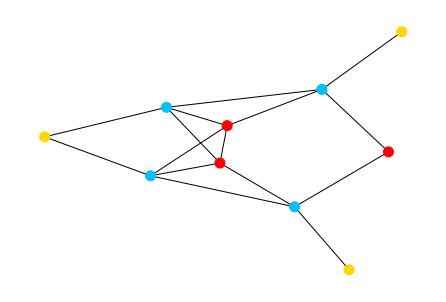

In [54]:
nx.draw(new_g,node_color=colors(X),node_size=100,width=1)

In [247]:
np.argmax(list(count.values()))

np.int64(86)

In [248]:
count

{0: 193,
 1: 29,
 2: 26,
 3: 38,
 4: 27,
 5: 24,
 6: 261,
 7: 25,
 8: 48,
 9: 502,
 10: 70,
 11: 265,
 12: 35,
 13: 55,
 14: 32,
 15: 26,
 16: 18,
 17: 120,
 18: 22,
 19: 9,
 20: 514,
 21: 15,
 22: 43,
 23: 38,
 24: 9,
 25: 36,
 26: 74,
 27: 8,
 28: 36,
 29: 23,
 30: 22,
 31: 53,
 32: 14,
 33: 23,
 34: 39,
 35: 11,
 36: 3,
 37: 164,
 38: 18,
 39: 7,
 40: 8,
 41: 11,
 42: 34,
 43: 166,
 44: 13,
 45: 16,
 46: 22,
 47: 104,
 48: 77,
 49: 69,
 50: 50,
 51: 4,
 52: 4,
 53: 14,
 54: 44,
 55: 494,
 56: 81,
 57: 156,
 58: 63,
 59: 21,
 60: 20,
 61: 16,
 62: 91,
 63: 140,
 64: 10,
 65: 4,
 66: 31,
 67: 20,
 68: 169,
 69: 87,
 70: 18,
 71: 48,
 72: 48,
 73: 60,
 74: 17,
 75: 16,
 76: 250,
 77: 72,
 78: 46,
 79: 11,
 80: 94,
 81: 78,
 82: 25,
 83: 262,
 84: 49,
 85: 32,
 86: 542,
 87: 100,
 88: 62,
 89: 77,
 90: 465,
 91: 79,
 92: 22,
 93: 6,
 94: 12,
 95: 24,
 96: 24,
 97: 4,
 98: 14,
 99: 23,
 100: 30,
 101: 17,
 102: 244,
 103: 97,
 104: 74,
 105: 43,
 106: 15,
 107: 16,
 108: 92,
 109: 75,
 1